# HERA Memo 45: H1C IDR 2.1 
## Calibrated, Flagged, and LST-Binned HERA Internal Data Release

### Josh Dillon, on behalf of the HERA Analysis Team

H1C IDR 2.1 is the first calibrated and LST-binned data release from H1C. The H1C observing campaign was the first science-grade HERA observing campaign with $\lesssim$100 antennas ("H" is for HERA and "1C" means $\sim$100). It started in September 2017 and continued through the beginning of April 2018.

This `jupyter` memo is designed to be run when logged into NRAO. For more information on access, see the [HERA wiki](http://hera.pbworks.com/w/page/119477181/NRAO%20Computing). For ongoing analysis results, see [this wiki page](http://hera.pbworks.com/w/page/124291248/H1C_IDR2%20Analysis) and the [#hera-analysis Slack channel](https://eoranalysis.slack.com/messages/C3ZPGMG3E).

In [1]:
!hostname

herapost007


The day-by-day data, along with the pipeline settings file used (`idr_v1.cfg`), and the LST-binned data can be found in:

In [2]:
ls /lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/

2458098/  2458102/  2458105/  2458108/  2458111/  2458114/  idr_v1.cfg
2458099/  2458103/  2458106/  2458109/  2458112/  2458115/  LSTBIN/
2458101/  2458104/  2458107/  2458110/  2458113/  2458116/  makeflow/


In [3]:
analysis_folder = '/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1'

## 1. Finding and Loading Data
H1C IDR 2.1 includes 18 nearly-consecutive nights of data. All data products are sorted by JD into the following folders on the NRAO servers, which also contain softlinks to raw H1C IDR 2 data and antenna metrics released by the commissioning team. Each night has 73 raw visibility files in each of the 4 visibility polarizations. Each file has 1024 frequency channels and (usually) 60 integrations, each 10.7374 seconds.

More information about the data products produced by the analysis team are [on the HERA wiki](http://hera.pbworks.com/w/page/123874272/H1C_IDR2).

In [4]:
import glob, os
for night in sorted(glob.glob(os.path.join(analysis_folder,'245*'))): 
    print night, 'has', len(glob.glob(night + '/*.uv')), 'raw visibility files.'

/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458098 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458099 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458101 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458102 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458103 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458104 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458105 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458106 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458107 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458108 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458109 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458110 has 292 raw visibility files.
/lustre/aoc/projects/hera/H1C_IDR2/IDR2_

The HERA collaboration's standard way to load in data files is using `pyuvdata` (for more, see [pyuvdata's documentation](http://pyuvdata.readthedocs.io/en/latest/)).

We can load in a sample data file like this:

In [5]:
bl = (65,71,'xx')
sample_data_file = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uv')

In [6]:
from pyuvdata import UVData
uvd = UVData()
uvd.read_miriad(sample_data_file)

To simplify the extraction of data and abstract away a lot of the complexity of a pyuvdata object, we can quickly get out the data and flags we're interested, along with the most useful metadata using `hera_cal.io`, a wrapper around `pyuvdata` for in-memory inspection, manipulation, and plotting of data. For keeping careful track of metadata for pipeline processes, it is often best to use `pyuvdata` directly.

In [7]:
from hera_cal import io
import numpy as np
(data, flags, antpos, ants, freqs, times, lsts, pols) = io.load_vis(uvd, return_meta=True)

# One can also load straight for a string path rather than a UVData object, e.g.:
# data, flags = io.load_vis(sample_data_file) 
print np.all(uvd.get_data(bl) == data[bl])

True


The `data` and `flags` loaded through `hera_cal.io.load_vis` are stored in `DataContainer` objects, which act like dictionaries mapping baseline tuples in the `(ant1,ant2,pol)` format like `(65,71,'xx')` to waterfalls of shape `(Ntimes, Nfreqs)`. DataContainers support getting data and flags via `[]` normation and a normal dictionary functions like `.keys()`, `.values()`, `.items()`, `.has_key()`. It also knows to conjugate data when the reversed baseline key is provided:

In [8]:
print np.all(data[65,71,'xx'] == np.conj(data[71,65,'xx']))

True


This then allows for easy data access and plotting, such as:

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

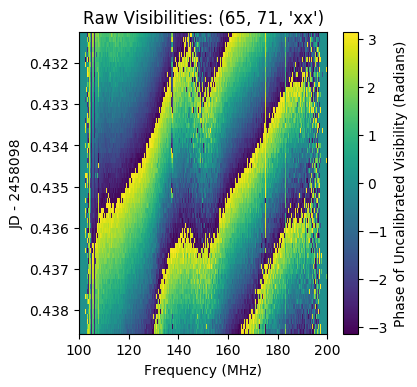

In [10]:
plt.figure(figsize=(4,4), dpi=100)
bl = (65,71,'xx')
plt.imshow(np.angle(data[bl]) / (~flags[bl]), aspect='auto',
           extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
plt.ylabel('JD - 2458098')
plt.xlabel('Frequency (MHz)')
plt.title('Raw Visibilities: ' + str(bl))
plt.colorbar(label='Phase of Uncalibrated Visibility (Radians)');

## 2. Array and Bad Antennas

The data taken for IDR2.1 began on 2458098 and ended on 2458116 with 52 antennas (~47 functional). Bad anntennas, as determined by the comissioning team, are summarized in this folder:

In [11]:
bad_ants_folder = '/users/heramgr/hera_software/hera_opm/hera_opm/data/idr2/bad_ants'
bad_ants = np.loadtxt(os.path.join(bad_ants_folder, '2458098.txt')).astype(int)
print 'Bad antennas on 2458098:', bad_ants

Bad antennas on 2458098: [  0   2  50  98 136]


We can visualize the array on 2458098 as follows:

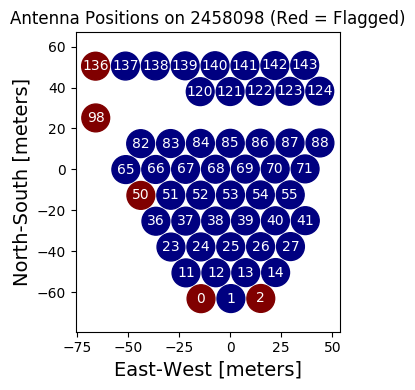

In [12]:
plt.figure(figsize=(4,4), dpi=100)

plt.scatter(np.array(antpos.values())[:,0], np.array(antpos.values())[:,1], 
            c=[ant in bad_ants for ant in antpos.keys()], s=400, cmap='jet')
for ant,pos in antpos.items():
    plt.text(pos[0],pos[1],str(ant), va='center', ha='center', color='w')
plt.xlabel("East-West [meters]", fontsize=14)
plt.ylabel("North-South [meters]", fontsize=14)
plt.title('Antenna Positions on 2458098 (Red = Flagged)');
plt.axis('equal')
plt.tight_layout()

All data in this IDR come from antennas in the Southwest sector of the split HERA core.

## 3. Day-by-Day Data Products and Access

### 3.1 Input Files
Raw HERA visibility for IDR2 by the commissioning team generally has the format `zen.2458098.43124.xx.HH.uv` which can be interpreted as:

* `zen`: zenith pointing
* `2458098`: julian date integer
* `43124`: first five decimal digits of the time of the first integration in the file 
* `xx`: visibility polarization. Options are `xx`, `xy`, `yx`, and `yy`
* `HH`: "Hera Hex", visibilities purely between hera core antennas
* `uv`: file extension conventionally used for miriad data files (which are technically folders)

Additionally, we inherit antenna metrics from the comissioning team. These come in json files with the format `zen.2458098.43124.HH.uv.ant_metrics.json`, one for all four visibility polarizations. These can be read `hera_qm.ant_metrics.load_antenna_metrics`:

In [13]:
from hera_qm.ant_metrics import load_antenna_metrics
am = load_antenna_metrics(os.path.join(analysis_folder, '2458098/zen.2458098.43124.HH.uv.ant_metrics.json'))
print 'Automatically detected bad antennas:', am['xants']

Automatically detected bad antennas: [(50, 'x')]


The list of bad antennas generated by `ant_metrics` is generally a subset of the flagged antennas, but both are ORed together on a file-by-file basis. There visibilities are still in all visibility data files, but their flag arrays are all `True`.

### 3.2 Visibility Data Files and Access

At each stage of the analysis, we produce new copies of the visibility data files in the same format as the raw data. Generally speaking, newly calibrated data is produced by applying calibration solutions (see below) to the raw `.uv` data files. Following the PAPER convention, these get a single letter suffix appended to denote what stage in the processing they represent (one can also look at their histories for more detailed analysis). They are:

* `zen.*.uv`: Raw data files from the comissioning team.
* `zen.*.uvO`: Partially-calibrated data files using both `firstcal` and `omnical`. These have only the first and last 50 channels flagged. **O** is for **O**mnical. 
* `zen.*.uvOC`: Calibrated data files using `firstcal`, `omnical`, and `abscal` (a sky-referenced) which as been restricted to operate in the degenerate subspace of `omnical`. That means that `abscal` is restricted to solving for [four numbers per frequency, integration, and polarization](https://arxiv.org/abs/1712.07212). These have the first and last 50 channels flagged and are flagged when the sun is up in either the data or the abscal model. **C** is for abs**C**al.
* `zen.*.uvOCR`: RFI-flagged, absolute calibrated datafiles. The data here are identical to the `.uvOC` data, only the flags are updated (but still include the band edge and solar flagging). **R** is for **R**FI.
* `zen.*.uvOCRS`: RFI-flagged, absolute calibrated data, the calibration solutions for which have been smoothed on 30 minute timescales and then 10 MHz frequency scales. **S** is for **S**moothed gains.
* `zen.*.uvOCRSD`: Delay-filted versions of the `.uvOCRS` files, which have been filtered at the horizon wedge + 15 ns using a Tukey window with $\alpha = 0.5$. **D** is for **D**elay filtered.

**Likely the `.uvOCRS` and `.uvOCRSD` files will be the most interesting, depending on whether you want data "with foreground" or "without foregrounds."**

*Note: the `.uvO` and `.uvOC` files are produced during the pipeline but then deleted to save space after they are no longer necessary. They can be straightfowardly reproduced using `hera_cal.apply_cal`.*

Again, we can use `pyuvdata` or `hera_cal.io` to look at the data.

In [14]:
abscaled_datafile = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uvOCRS')
filtered_datafile = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uvOCRSD')

abscaled_data, abscaled_flags = io.load_vis(abscaled_datafile)
filtered_data, filtered_flags = io.load_vis(filtered_datafile)

divide by zero encountered in divide
invalid value encountered in divide


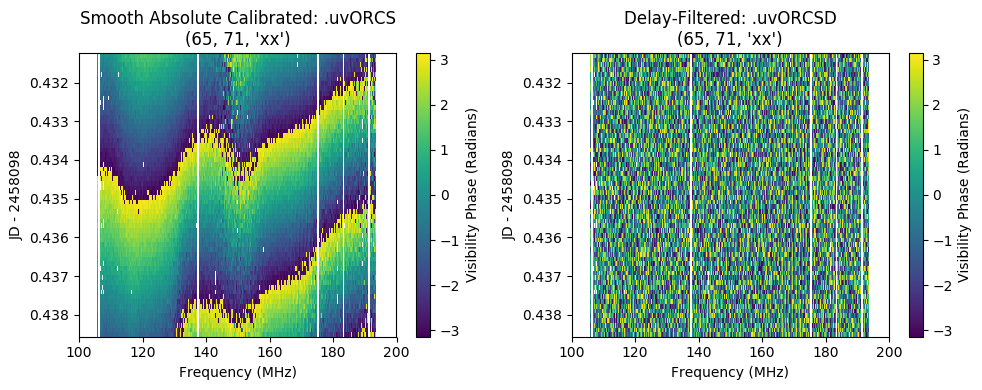

In [15]:
bl = (65,71,'xx')
plt.figure(figsize=(10,4), dpi=100)
for data, flags, sub, t in zip([abscaled_data, filtered_data], [abscaled_flags, filtered_flags], 
                            [121, 122], ['Smooth Absolute Calibrated: .uvORCS', 'Delay-Filtered: .uvORCSD']): 
    plt.subplot(sub)
    plt.imshow(np.angle(data[bl]) / (~flags[bl]), aspect='auto',
               extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
    plt.title(t + '\n' + str(bl))
    plt.ylabel('JD - 2458098')
    plt.xlabel('Frequency (MHz)')
    plt.colorbar(label='Visibility Phase (Radians)');
plt.tight_layout()    

divide by zero encountered in divide
invalid value encountered in divide
invalid value encountered in less_equal


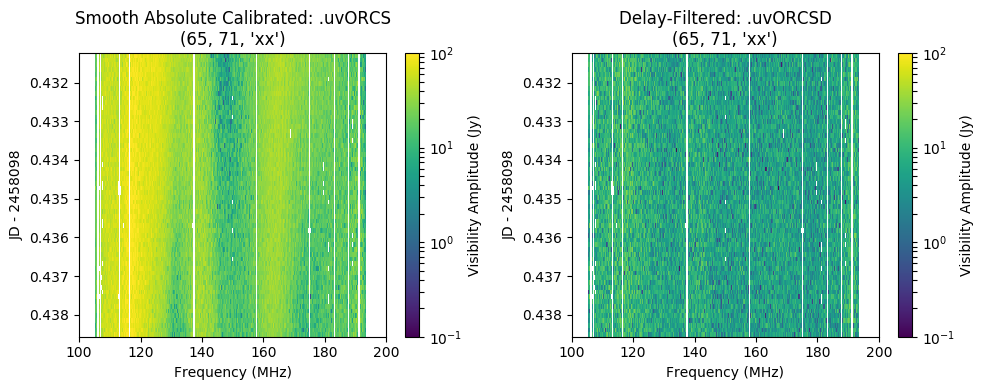

In [16]:
import matplotlib
bl = (65,71,'xx')
plt.figure(figsize=(10,4), dpi=100)
for data, flags, sub, t in zip([abscaled_data, filtered_data], [abscaled_flags, filtered_flags], 
                            [121, 122], ['Smooth Absolute Calibrated: .uvORCS', 'Delay-Filtered: .uvORCSD']): 
    plt.subplot(sub)
    plt.imshow(np.abs(data[bl])/(~flags[bl]), aspect='auto', norm=matplotlib.colors.LogNorm(1e-1,1e2),
               extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
    plt.title(t + '\n' + str(bl))
    plt.ylabel('JD - 2458098')
    plt.xlabel('Frequency (MHz)')
    plt.colorbar(label='Visibility Amplitude (Jy)');
plt.tight_layout()  

### 3.3 Calibration Files and Access

Along the pipeline, we produce and save four progressively refined calibration solutions that can be applied to raw data, meaning that they supplant previous calibrations. These are stored in the `calfits` format and have a form like `zen.2458098.43124.xx.HH.uv.first.calfits`. Calibration solutions are per-antenna, not per baseline, so `xx` really just means `x` and there are no `xy` or `yx` calfits files. They are:

* `zen.*.uv.first.calfits`: The output of `firstcal`, which solves for the relative delays between antennas.
* `zen.*.uv.omni.calfits`: The output of `omnical`, which uses redundancy to solve for calibrations solutions for all times and frequencies up to 4 degenerate modes per frequency, per time, and per polarization. 
* `zen.*.uv.abs.calfits`: The output of `abscal`, which ties the omnical solutions to the sky and picks a single reference antenna (53 for IDR2.1) to have 0 phase for all times. 
* `zen.*.uv.smooth_abs.calfits`: The output of `smooth_cal`, which takes `.abs.calfits` calibration solutions and smooths them on 30 minute and then 10 MHz scales. This restricts the degrees of freedom available to calibration. 

Each of these calibration files also comes with its own flags. `.first.calfits` and `.omni.calfits` files generally have no flags, through bad antennas are simply not present. `.abs.calfits` can inherit flags from the abscal model and also flags times when the sun was up in either the data or the abscal model. `.smooth_abs.calfits` includes the `.abs.calfits` flags, but also includes flags from RFI excision that have been synthesized so that any flagged visibility that isn't with a totally-flagged antenna leads to a flag on both antenna's calibrations.

Again, one can either use `pyuvdata.UVCal` to load in calibration solutions, or use `hera_cal.io`'s simple wrapper for loading calibration solutions into memory as python dictionaries.

In [17]:
firstcal = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uv.first.calfits')
g_fc, f_fc = io.load_cal(firstcal)

omnical = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uv.omni.calfits')
g_oc, f_oc, quals, total_qual, ants, freqs, times, pols = io.load_cal(omnical, return_meta=True)

abscal = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uv.abs.calfits')
g_ac, f_ac = io.load_cal(abscal)

smoothcal = os.path.join(analysis_folder, '2458098/zen.2458098.43124.xx.HH.uv.smooth_abs.calfits')
g_sc, f_sc = io.load_cal(smoothcal)

divide by zero encountered in divide


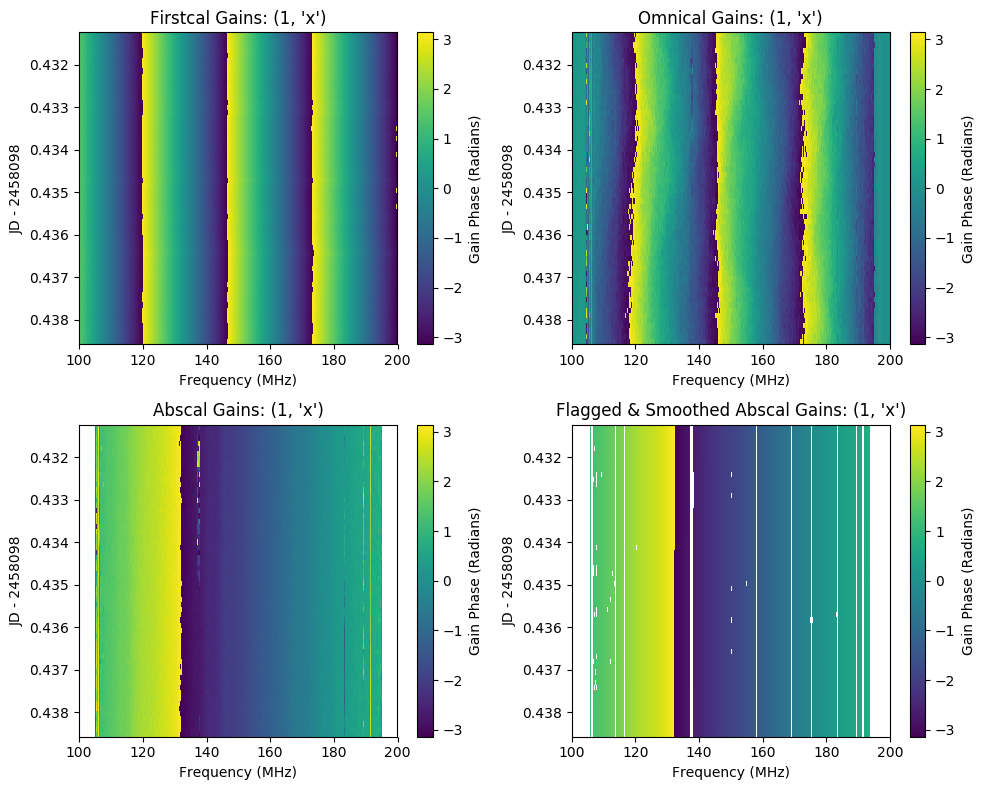

In [18]:
ant = (1,'x')
phs = plt.figure(figsize=(10,8), dpi=100)
for g, f, sub, t in zip([g_fc, g_oc, g_ac, g_sc], [f_fc, f_oc, f_ac, f_sc], [221, 222, 223, 224],
                        ['Firstcal', 'Omnical', 'Abscal', 'Flagged & Smoothed Abscal']): 
    plt.subplot(sub)
    plt.imshow(np.angle(g[ant]) / (~f[ant]), aspect='auto',
               extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
    plt.title(t + ' Gains: ' + str(ant))
    plt.ylabel('JD - 2458098')
    plt.xlabel('Frequency (MHz)')
    plt.colorbar(label='Gain Phase (Radians)');
plt.tight_layout()    

Additionally, all `.calfits` files after firstcal inherit copies of `omnical`'s $\chi^2$, which is an unnormalized metric of non-redundancy after calibration given by

$\chi^2(\nu,t) = \sum_{i,j}\left|V_{ij}^\text{obs}(\nu,t) - g_i(\nu,t) g_j^*(\nu,t) V_{ij}^\text{sol}(\nu,t)\right|$.

This is stored in the `total_quality_array` attribute of a calfits object and is accessible via `hera_cal.io` using the `return_meta` keyword argument (see above). This also useful for flagging. It looks like:

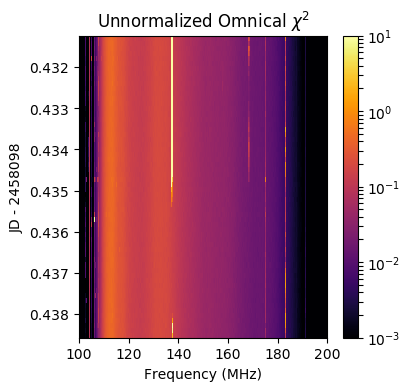

In [19]:
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(total_qual['x'], aspect='auto', norm=matplotlib.colors.LogNorm(1e-3,1e1), cmap='inferno',
           extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
plt.ylabel('JD - 2458098')
plt.xlabel('Frequency (MHz)')
plt.title('Unnormalized Omnical $\chi^2$')
plt.colorbar();

Additionally `omnical` produces a couple of other data productions:

* `zen.*.uv.vis.uvfits`: These are the omnical visibility solutions stored in the uvfits format (not miriad, like the other visibilities in IDR 2.1. Omnical produces one visibility. This are used in finding RFI, but are not further calibrated right now.
* `zen.*.uv.xtalk.uvfits`: These are omnical's estimates of the crosstalk between the antennas in the baseline (i.e. correlated noise) obtained by averaging over the data file. As such, they only contain a single "integration." They are not currently used for anything.

### 3.4 Quality Metrics and Flagging Metadata
The parts of the pipeline that fall under the aegis of `hera_qm` produce a number of useful intermediate and summary data products that can help assess the quality of calibration solutions and the results of the iterative RFI flagging routines used.

#### Quality Metrics
Combined with the RTP output from the comissioning team, we produce and store 3 different `.json` files that assess the quality of the array. These are:

* `zen.*.uv.ant_metrics.json`: These include a list of antennas that are suspected of being dead or cross-polarized, along with a variety of intermediate results summarizing the extent to which each antenna is an outlier. See [this example notebook](https://github.com/HERA-Team/hera_qm/blob/master/scripts/ant_metrics_example_notebook.ipynb) for more details about the creation and interpretation of these metrics.
* `zen.*.uv.first.calfits.firstcal_metrics.json`: These includes a variety of metrics assesing the stability of `firstcal` solutions as a function of time. They also include information about antennas that are believed to be 180 degrees rotated, meaning that their delay intersects $\pi$ instead of 0. These files are not currently used in the pipeline. See [this example notebook](https://github.com/HERA-Team/hera_qm/blob/master/scripts/firstcal_metrics_example.ipynb) for more details about the creation and interpretation of these metrics.
* `zen.*.uv.omni.calfits.omnical_metrics.json`: These include metrics that assess whether any antenna appears to be performing perticularly poorly in omnical, either in its contribution to $\chi^2$ or the standard deviation of its gain phase across frequency. These files are not currently used in the pipeline. See [this example notebook](https://github.com/HERA-Team/hera_qm/blob/master/scripts/omnical_metrics_example.ipynb) for more details about the creation and interpretation of these metrics.




#### Flagging Files
Additionally, there are a number of `.npz` files that contain flags and flagging metadata that can help reconstruct the decisions made by the RFI flagging algorithm. These can all be opened with a standard `np.load()`.

* `zen.*.uv.vis.uvfits.flags.npz`: flags and flagging metadata produced using the `omnical` unique baseline visibility solutions.
* `zen.*.uv.abs.calfits.g.flags.npz`: flags and flagging metadata produced using `abscal` gain solutions.
* `zen.*.uv.abs.calfits.x.flags.npz`: flags and flagging metadata produced using `omnical` $\chi^2$.
* `zen.*.uvOC.flags.npz`: flags and flagging metadata produced from delay-filtered data that has been pre-flagged with flags based on calibration data products above.
* `zen.*.uvOC.xrfi_summary.npz`: flagging metadata and summary produced using [this function](https://github.com/HERA-Team/hera_qm/blob/ba3000b5a4325f22853ba5f7dbe587927d54438d/hera_qm/xrfi.py#L620).
* `zen.*.uvOCR.flags.applied.npz`: summary of all flags applied to data 

The `zen.*.uvOC.flags.npz` and `zen.*.uvOCR.flags.applied.npz` can be converted into DataContainers of flags using:

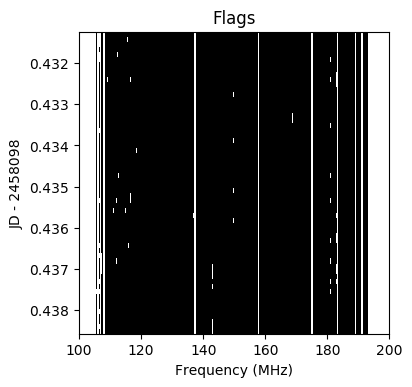

In [20]:
applied_flags = io.load_npz_flags(os.path.join(analysis_folder, 
                                  '2458098/zen.2458098.43124.xx.HH.uvOCR.flags.applied.npz'))
bl = (65,71,'xx')
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(applied_flags[bl], aspect='auto', cmap='gray',
           extent=[freqs[0]/1e6,freqs[-1]/1e6,times[-1]-2458098,times[0]-2458098])
plt.ylabel('JD - 2458098')
plt.xlabel('Frequency (MHz)')
plt.title('Flags');

## 4. LST-Binned Data Products

LST-binned HERA visibility data generally has the format `zen.grp1.of2.xx.LST.1.28828.uvOCRSL` which can be interpreted as:

* `zen`: zenith pointing
* `grp1`: 1-indexed group of nights that the LST binned data products are divided into
* `of2`: number of groups of nights that the data was divided into before separately LST-binning each group together
* `LST`: LST-binned data. The other alternative is `STD`, which encodes the standard deviation of the real and imaginary parts (separately) of the binned data in its real and imaginary data array
* `1.28828`: starting LST of the data in radians
* `uvOCRSL`: extension for calibrated, RFI-flagged, LST-binned data, but not delay-filtered. The LST-binned results also include `uvOCRSDL` files, which have been delay-filtered.  **L** is for **L**ST-binning.

In general, LST-binned data files are also 60 integrations, but each integration is 21.475 seconds, double the integration time of the raw data files. 

The data can be found in `/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/{one/two/three}_group/grp{N}/`.

For the nights split into two groups, we have:
* grp1: 2458098, 2458101, 2458103, 2458105, 2458107, 2458109, 2458111, 2458113, 2458115
* grp2: 2458099, 2458102, 2458104, 2458106, 2458108, 2458110, 2458112, 2458114, 2458116

For the nights split into three groups, we have:
* grp1: 2458098, 2458102, 2458105, 2458108, 2458111, 2458114
* grp2: 2458099, 2458103, 2458106, 2458109, 2458112, 2458115
* grp3: 2458101, 2458104, 2458107, 2458110, 2458113, 2458116

The lst-binned data are also stored in the miriad format and accessible via `pyuvdata` or `hera_cal.io`:


In [21]:
lstbinned = os.path.join(analysis_folder,'LSTBIN/two_group/grp1/zen.grp1.of2.xx.LST.1.28828.uvOCRSL')
l_uvd = UVData()
l_uvd.read_miriad(lstbinned)
(l_data, l_flags, l_antpos, l_ants, l_freqs, l_times, l_lsts, l_pols) = io.load_vis(l_uvd, return_meta=True)

antenna_diameters is not set. Using known values for HERA.


divide by zero encountered in divide
invalid value encountered in divide


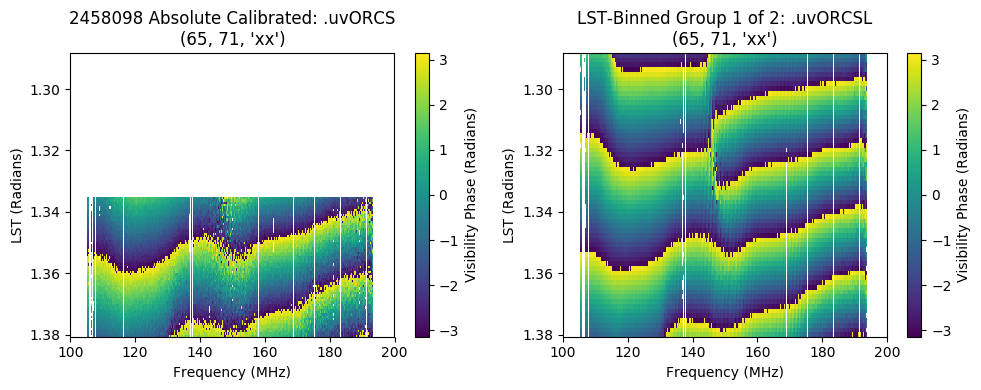

In [22]:
bl = (65,71,'xx')
plt.figure(figsize=(10,4), dpi=100)
for d, f, sub, l, t in zip([abscaled_data, l_data], [abscaled_flags, l_flags], 
                            [121, 122], [lsts, l_lsts],
                            ['2458098 Absolute Calibrated: .uvORCS', 'LST-Binned Group 1 of 2: .uvORCSL']): 
    plt.subplot(sub)
    plt.imshow(np.angle(d[bl]) / (~f[bl]), aspect='auto',
               extent=[freqs[0]/1e6,freqs[-1]/1e6,l[-1],l[0]])
    plt.title(t + '\n' + str(bl))
    plt.ylabel('LST (Radians)')
    plt.xlabel('Frequency (MHz)')
    plt.colorbar(label='Visibility Phase (Radians)');
    plt.ylim([l_lsts[-1],l_lsts[0]])
plt.tight_layout()    

Note that a single LST-binned data file covers twice as much time as a single data file because the integrations are twice as long. Note also that the LST-binned data will in general have fewer flags than the observation on a single night because LST-binned data is only flagged when all the input data is flagged. However, the statistics of the data are available in two places. The first is the standard deviations of the data that go into each LST bin. The standard deviations of the real and imaginary parts are computed separately and stored as the real and imaginary parts of the visibility data in the `zen.*.STD.*` files. Second is the `nsample_array` which is accessible through `pyuvdata` using `get_nsamples()`.

In [23]:
lst_stds, _ = io.load_vis(os.path.join(analysis_folder,'LSTBIN/two_group/grp1/zen.grp1.of2.xx.STD.1.28828.uvOCRSL'))

divide by zero encountered in divide


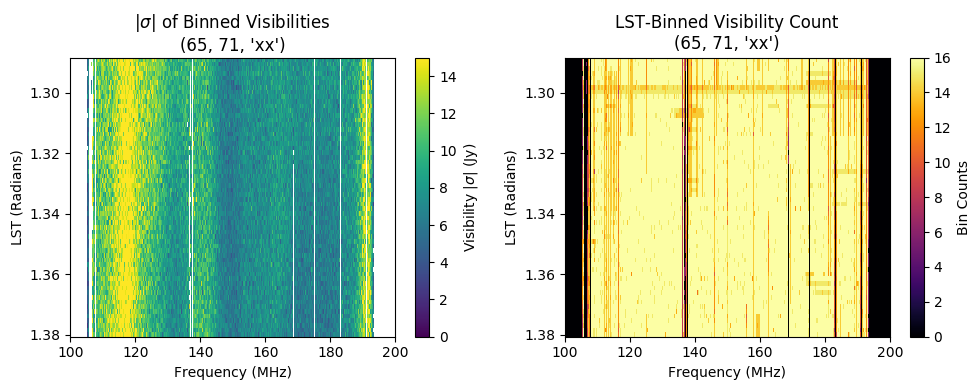

In [24]:
bl = (65,71,'xx')
nSamples = l_uvd.get_nsamples(bl)
plt.figure(figsize=(10,4), dpi=100)
plt.subplot(121)
plt.imshow(np.abs(lst_stds[bl]) / (~l_flags[bl]), aspect='auto',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, l_lsts[-1], l_lsts[0]])
plt.colorbar(label='Visibility $|\sigma|$ (Jy)');
plt.ylabel('LST (Radians)')
plt.xlabel('Frequency (MHz)')
plt.title('$|\sigma|$ of Binned Visibilities\n' + str(bl))
plt.clim([0,15])

plt.subplot(122)
plt.imshow(l_uvd.get_nsamples(bl) , aspect='auto', cmap='inferno',
           extent=[freqs[0]/1e6, freqs[-1]/1e6, l_lsts[-1], l_lsts[0]])
plt.colorbar(label='Bin Counts');
plt.ylabel('LST (Radians)')
plt.xlabel('Frequency (MHz)')
plt.title('LST-Binned Visibility Count\n' + str(bl))
plt.tight_layout()  

## 5. Analysis Steps and Pipeline 

The data products are produced by a pipeline managed by [Makeflow](http://ccl.cse.nd.edu/software/makeflow/). The pipeline is built using the tools in [hera_opm](https://github.com/HERA-Team/hera_opm) repo and using [shell scripts](https://github.com/HERA-Team/hera_opm/tree/master/hera_opm/data/idr2/task_scripts) and [settings](https://github.com/HERA-Team/hera_opm/blob/master/hera_opm/data/idr2/idr_v1.cfg) for them. These thin bash scripts use one of the scripts in [hera_cal](https://github.com/HERA-Team/hera_cal/tree/master/hera_cal) or [hera_qm](https://github.com/HERA-Team/hera_qm/tree/master/hera_qm), which themselves use various unittested modules in those repositories. 

A broad overview of the interdependencies of the processing can be cleaned from this flowchart:

![HERA Analysis Workflow](https://i.imgur.com/x90Jlqi.png)

In yellow ovals, we see the data products described above and how they were created. Red and magenta diamonds represent the various discrete steps in the pipeline. We will now review the methods in broad terms, highlighting some of the analysis choices made.

### 4.1 Redundant Calibration

Redundant-baseline calibration takes place in two steps. The first is `firstcal`, which uses redundancy to solve for the relative delays between antennas. It cannot solve for an overall delay, delay gradients across the array, or the relative delay between x and y polarizations. Also, if an antenna drops out between files, there may be a jump in the firstcal solution for a specific antenna. All of theses issues are resolved in `abscal`.

The second step is `omnical`, which implements redundant baseline calibration with full generality, treating each time and frequency completely independently and solving for gains $g_i(t,\nu)$ in the equation:

$V_{ij}^\text{obs}(t,\nu) = g_i(t,\nu) g_j^*(t,\nu) V_{ij}^\text{sol}(t,\nu)$

where $V_{ij}^\text{obs}(t,\nu)$ are the data (pre-calibrated with `firstcal`) and $V_{ij}^\text{sol}(t,\nu)$ are the unique baseline visibilities. Omnical operates in `1pol` mode, meaning that each polarization is caluclated independenly and xy and yx visbilities are not used in calibration. Each time, frequency, and polarization has four degeneracies:
* Overall amplitude
* Overall phase
* North-South phase gradient
* East-West phase gradient

For a more detailed, pedagogical explanation of the degeneracies of redundant-baseline calibration, see [Section 2 of this paper.](https://arxiv.org/abs/1712.07212)

Omnical fixes the degeneracies so that (after dividing out the firstcal solution), the average gains are 1 and the average phase phases and phase slopes are set to 0 for all times and frequencies. This ensures spectral smoothness of the degenerate part of the calibration solutions, though it can create temporal discontinuties that have to be taken out by abscal. 

When omnical solutions are applied to data to produce `.uvO` files, (and during all subsequent `apply_cal` steps), the first and last 50 channels are flagged by hand. These tend to be pretty deep into the instrument's bandpass and flagging them by hand makes subsequent analysis steps more robust.

### 4.2 Absolute Calibration

The next step in calibration is absolute calibration or `abscal`. Absolute calibration attaches the `omnical` gain solutions to a sky reference, allowing us to fix the degeneracies. In fact, absolute calibration is restricted to only modify the degenerate subspace of the omnical solutions; only four degrees of freedom per polarization per time per frequency are allowed to be modified.

Instead of using a point source model, `abscal` takes as its input a "model," which can be either simulated visibilities or, as in our case, absoluate calibrated visibilities. Nearest neighbors in LST are phased to match the data set to be calibrated and then the four omnical degeneracies are solved for by comparing the ratio of the "data" and "model" visibilities and solving a system of equations where each visibility in the data is given equal weight. For fixing the overall amplitude, this happens in a single step. For fixing the phase gradients, abscal takes an approach that iteratively refines the solutions in order to avoid issues with phase wrapping. First abscal solves for a spatial (i.e. across the array) delay slope. Next it solves for an averge (across frequency) spatial phase slope. Finally, it solves for phase slopes across the whole array. Finally, the absolute phase (which is unphysical and not calibratable by reference to a sky model) is fixed by picking a reference antenna. **For IDR2.1, we define antenna 53 to have zero phase in both x and y polarizations** because it is never observed to die and because it is near the center of the array. Picking a reference antenna is important for later calibration smoothing.

The `abscal` calibration model is actually one of the days of the IDR, 2458116, calibrated in CASA independently of the above pipeline. Its calibration is determined using a handful of point sources around the 17.5 Jy source GLEAM J0200-3053 that passes near zenith. The complex gains derived from that single field are assumed to be accurate gains for the entire night and are applied to the entire day of data. More information about the making of the abscal model for IDR2.1 [is available on the HERA wiki](http://hera.pbworks.com/w/page/124291248/H1C_IDR2%20Analysis) and in [HERA Memo #42.](http://reionization.org/wp-content/uploads/2013/03/abscal_memo.pdf)

To lower the noise in the data and interpolate over RFI, the visibilities are delay-filtered with a [Tukey window](https://en.wikipedia.org/wiki/Window_function#Tukey_window) with $\alpha=0.5$ and only the smooth components kept (those with delays less than the horizon delay for a baseline plus a 150 ns buffer). A few integrations are completely flagged and thus cannot be interpolated over in this way; those flags are propagated into the data.

Finally, we flag any data during which the sun is above the horizon. These cannot be absolute calibrated because the sun is in a different position in the data and in the abscal model. Likewise, we also flag any data during LSTs that correspond to times on 2458116 when the sun is up because we also expect major differences between the data and the model. 

### 4.3 RFI Flagging

Our Radio Frequency Interference (RFI) flagging algorithm takes place in two steps, dubbed `cal_xrfi` and `delay_xrfi`. In the first, we look for outliers in either the omnical $\chi^2$, the abscal gain amplitudes, or the omnical unique baseline visibility solutions. In the latter, we take the output of the `cal_xrfi` flags, apply them to absolute-calibrated `.uvOC` files, delay filter the visibilities at the horizon (plus a 15 ns buffer) using a Tukey window, and again look for outliers. Our experience has shown that narrow-spectrum, low-level RFI stands out better in delay-filtered data.

In both flagging routines, each dataset undergoes outlier detection in two steps. First, each point (gain, $\chi^2$, or visibility) is converted to a number of $\sigma$s by subtracting a median-filtered version of the data (over a 17 x 17 box in frequency channels and time integrations) and comparing this residual to a median filtered residual squared (essentially, a notion of the local variance). Points above $6\sigma$ are considered flag candidates. Finally, any point neighboring a flagged point that is above $2\sigma$ is also considered a flag candidate.

Each of the three flag arrays are subsequently broadcast to a single waterfall (i.e. frequency vs. time). First, a flag-candidate fraction waterfall is computed. If the mean flag-candidate fraction for a given integration is greater than 25%, the entire integration is flagged. Likewise, if the mean  fraction for a given frequency in a file is greater than 5%, the entire frequency is flagged for the file. Finally, any "pixel" in the waterfall (i.e. a single time and frequency) is a candidate for flagging more than 10% of the time, that frequency and time and flagged for all baselines. Only these "thresholded" flags are carried forward.

These waterfalls are then ORed together before the `delay_xrfi` step, which then goes through another round of the watershed algorithm, flagging, and broadcasting to a single waterfall. The result is that the RFI excision per-frequency and per-time flags for all baselines. Flags can only vary from one baseline to another if they were imposed earlier in the pipeline. Calibration smoothing will subsequently broadcast any per-baseline flags to both baselines involved.



### 4.4 Calibration Smoothing

To reduce the number of degrees of freedom in the calibration solution, we rely on the presumption that the instrument does not have spectral structure on small frequency scales and that it does not evolve quickly in time. After RFI flagging (and harmonizing those flags on an antenna rather than baseline level, though they are generally identical from baseline to baseline), we smooth both the real and imaginary parts of our `abscal` calibration solutions and then reapply them to data to produce the `.uvOCRS` files. 

Our smoothing algorithm loads in a whole day of calibration solutions simultaneously and put them on a time grid, leaving flagged holes for any missing files or missing time. We smooth in time using Gaussian kernel with a a 30 minute FWHM that is renormalized for each time dependening on flagging. This means that times near flags might get extra weight in this smoothing. To smooth the beginning and end of the night, we mirror the dataset before smoothing to ensure continuity. Finally, we apply a delay-filter on 10 MHz (or 100 ns) scales using a Tukey window with $\alpha=.3$ (which gives a bit more weight to the band edges) and keep the smooth components. These are finally written to disk as the `.smooth_abs.calfits` files.

### 4.5 Delay Filtering

In addition to the `.uvOCRS` data files, we also run all of our data through one more delay filter before LST-binning, producing `.uvOCRSD` files as well where the spectrally smooth part of the data has been subtracted.(see the bifurcation at the bottom of the above flow diagram). The delay filtering is done with a Tukey window with $\alpha=0.5$ at each baseline's horizon delay (plus a 15 ns buffer) and with a $10^{-9}$ tolerance for the delay CLEANing algorithm, which is used to iteratively remove spectral components despite irregular RFI flagging.

### 4.6 LST-Binning

Both before and after delay filtering, the data is LST-binned into a single group, into two groups of interleaved nights, and into three groups of interleaved nights. During LST binning, each integration is assigned to the the nearest LST bin, but is rephased to account for the slight difference in LST between its bin center and the LST bin's center. LST bins were chosen to be twice as long as raw data bins (21.475 seconds = 0.00156597 radians of a sidreal day), so every LST bin gets two data points for every input night.

Next, the list of rephased data points that would go into any given LST and frequency bin are examined for outliers. For relatively robust outlier detection, we compute the [median absoute deviation (MAD)](https://en.wikipedia.org/wiki/Median_absolute_deviation) of all the points that are to be binned together and use that to compute a modified z-score. As long as there are at least 5 data points to bin together, we then flag all data that with a modified z-score greater than 5, which corresponds to $5\sigma$ outliers if the distribution were Guassian.

Finally, we compute the standard deviation of both the real and imaginary parts of the unflagged data and store those in the `.STD.` file. We also save the number of samples that went into each binned data point in both the `.LST.` and `.STD.` files. We do not further perform a cut on the number of samples or any other form of post-LST binning RFI flagging. 


## 5. Known Issues, Future Improvements, and Open Questions

The goal of IDR 2.1 was to produce data that could lead to an astrophysically interesting power spectrum upper limit. The above is merely one step in a continually improving HERA analysis pipeline. There are a number of known issues 
which we are working to address in future data releases:


* **Cable Reflections**. We know that our 150 m cables exhibit reflections on the $\sim$1000 ns ($\sim$1 MHz). While abscal and omnical pick up these cable reflections in our calibration solutions, we effectively eliminate them from our calibration solutions after smoothing due to the frequency smoothing on 10 MHz scales. This means that the calibrated data should have the cable reflections in them, more or less uncorrect. 


* **Flagging broadcasting and thresholding**. Right our our flagging algorithm is a bit ad hoc and performs broadcasting and thresholding in mutiple stages. We believe this leads to overflagging, especially since since the broadcasting in time is done on a file-by-file basis. Improving this algorithm is a high priority for the next IDR (see e.g. [this GitHub issue](https://github.com/HERA-Team/hera_cal/issues/299)).


* **Temporal structure in gains even after smoothing**. Because our calibration smoothing algorithm smooths in time and frequency separately, frequency smoothing can introduce some temporal structure (and vice versa). Since frequency smoothness is far more important, we were willing to accept a small amount of temporal structure.  There's a [an issue out to fix this](https://github.com/HERA-Team/hera_cal/issues/298) by implementing 2D smoothing in both time and frequency simultaneously. 


* $\chi^2$ **is unnormalized**. Right now, the $\chi^2$ that omnical calculates in unnormalized, meaning that the difference between the data and the gain-visibility solution product that should replicate it is not normalized by the noise in the data. There are a number of ways to estimate this noise, including using the autocorrelations, and we plan to improve redundant calibration to include this information. Next season, when we implement even-odd time interleaving at the sub-integration level, this will be much easier. [This is an open issue too.](https://github.com/HERA-Team/hera_cal/issues/301)


* **Occasional abscal phase failures**. We've seen evidence for a handful of integrations not converging to the same phase solution across the the band as their neighbors. This appears to be a problem with abscal and is similar to the convergence issues we saw before which were due to phase wrapping. While these don't generally affect the final solutions much (smooth_cal basically smooths over these discontinutities), we need a robust way of identifying and flagging these integrations when the absolute calibrated dataset is very discrepant from the abscal model. [There's an open issue on this too.](https://github.com/HERA-Team/hera_cal/issues/311)


* **Limitations of the abscal model**. Our absolute calibration model is rather simple, using the calibration solutions from a single field on a single day to calibrate an entire data set. This can be improved by calibrating several fields on several days and stringing together a data set that spans the full range of nighttime LSTs in the data. One can also imagine fringe-rate filtering the model (instead of just delay-filtering it) to make it less noisy and more sky-like. Alternatively, one could instead develop a model for calibration based on simulations. This requires fairly accurate beam and sky knowledge, which is a major challenge, but might be the only way to bring `abscal` into the RTP next season.


* **Cross-talk**. Even after the delay filter, we see clear evidence of persistant structure on short baselines. This was seen in PAPER and is likely attributable to cross-talk. We make no effort in this IDR to remove that cross-talk, but it should probably be done after LST-bining and and on timescales longer than a single file. This is tied up in the question of how to time-average and/or fringe-rate filter the data before estimating the delay power spectrum and will need to be addressed by the power spectrum pipeline.


* **Problems with 2458108.51325**. The pipeline got stuck on these files for `delay_xrfi`. We decided to manually flag all the abscal gains for the file for both polarizaions. We should revisit this to see why the delay filter wouldn't converge. 

Over the past several months, the Analysis team has accumulated a series of research questions that we think ought to be looked into using this data set. This includes:

* **Temporal structure**. How stable are the calibration solutions in time (per feed)? What kind of temporal structure do they exhibit and how repeatable is that structure from day to day? What is the optimal temporal smoothing scale for calibration solutions?

* **Spectral structure**. What kind of spectral structure do our calibration solutions exhibit? How does it vary from antenna to antenna? From integration to integration? From day to day? Is the spectral structure in our calibration solutions consistent with that expected from beam modeling of spectral structure? What is the optimal spectral smoothing scale for calibration solutions? Is there some spectral form other than delay modes on which we should be filtering (e.g. Hermite polynomials? PCA/Weiner filter?).

* **Characterizing cable reflections**. What do the cable relflections look like and how do they vary from antenna to antenna nd time to time? Is there any relationship between the NRAO and Cambridge handware? 

* **RFI**. Is there any low level RFI that we are not detecting? Does the LST-binned data product show any evidence for RFI? How should we be removing RFI after LST binning?

* **Versus Sky-Based Calibration**. How do the calibration solutions compare to those generated purely from a sky-based calibration? 

* **Imaging**. How do images look? Do source fluxes and spectra look right? What about psuedo-Stokes I, Q, U, and V images?

* **Noise integration.** Does the noise integrate down from day to day? 

* **LST results.** Does the difference between a given day's data and the corresponding LST-binned data look noise-like? Are there some days that are worse than others?

* **Noise modeling**. Is the noise in the data consistent with our noise model using the autocorrelations?

* **Redundancy.** How redundant are redundant baselines? Does the noise integrate down inside redundant baseline groups?

* **Repeatablility of calibrated data**. How repeatable are redundant baselines from day to day after calibration?

* **Beams**. Does our beam model make sense? Can we constrain it with foregrounds moving through the beam?

* **Delay filtering**. We use delay filtering in XRFI, calibration smoothing, and the delay filtering step. Are we using the best algorithm for it? Are we using the best tapering function?

* **Delay spectrum.** How does the delay spectrum look? Is it noise-like at k~.2 and beyond after foreground filtering on the EoR baselines? How does it depend on LST?


If you want to work on any of these questions (or already are!) or are curious about this IDR, please join our  HERA analysis telecon on [Tuesdays at 10am Pacific on Zoom](https://berkeley.zoom.us/j/446119451) or the [#hera-analysis Slack channel](https://eoranalysis.slack.com/messages/C3ZPGMG3E). 